# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

## Read the CSV and Perform Basic Data Cleaning

In [4]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


## Split the Data into Training and Testing

In [5]:
# Create our features
X = df.drop(columns='loan_status')

# Create our target
y = df['loan_status']



In [6]:
# Turn non-numbers to dummies (I checked; there are no integers in the dataset. If it's not a float we need to one-hot it)
col_list = (X.columns.to_list())
a = []
for col in col_list:
    if X[col].dtype != 'float64':
        a.append(col)
X = pd.get_dummies(X, columns=a)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)

In [8]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [10]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=1000, random_state=1)
brf.fit(X_train_scaled, y_train)

BalancedRandomForestClassifier(n_estimators=1000, random_state=1)

In [11]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = brf.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)


0.8196061012606211

In [ ]:

# Display the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

In [15]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.05      0.71      0.93      0.09      0.81      0.65        87
   low_risk       1.00      0.93      0.71      0.96      0.81      0.67     17118

avg / total       0.99      0.93      0.71      0.96      0.81      0.67     17205



<AxesSubplot:title={'center':'Features Importances: Top 10'}, ylabel='1'>

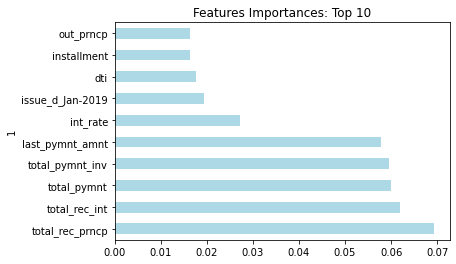

In [16]:
# List the features sorted in descending order by feature importance
importances_df = pd.DataFrame(sorted(zip(brf.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances', ascending=False)
importances_sorted.head(10).plot(kind='barh', color='lightblue', title= 'Features Importances: Top 10', legend=False)

### Easy Ensemble Classifier

In [18]:
# Train the Classifier
from imblearn.ensemble import EasyEnsembleClassifier
ee_learner = EasyEnsembleClassifier(n_estimators=1000, random_state=1)
ee_learner.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(n_estimators=1000, random_state=1)

In [19]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred_ee = ee_learner.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred_ee)


0.9265665099451676

In [20]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_ee)

array([[   79,     8],
       [  940, 16178]], dtype=int64)

In [21]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred_ee))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.08      0.91      0.95      0.14      0.93      0.86        87
   low_risk       1.00      0.95      0.91      0.97      0.93      0.86     17118

avg / total       0.99      0.94      0.91      0.97      0.93      0.86     17205



### Final Questions

1. Which model had the best balanced accuracy score?

    EE Clasifier.

2. Which model had the best recall score?

    EE Clasifier.

3. Which model had the best geometric mean score?

    EE Clasifier.

4. What are the top three features?

    total_pymnt , 
    total_rec_int , 
    total_rec_prncp , 